In [ ]:
# 两个相同的模型同时进行训练
# 查看一下模型的偏离程度

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Subset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

import time
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score

In [5]:
# 看一下设备数量
device_count = torch.cuda.device_count()
print(f"Device count: {device_count}")
for i in range(device_count):
    print(torch.cuda.get_device_properties(i))
    
# 设置计算端
computing_device = "cpu"
if torch.cuda.is_available():
    computing_device = "cuda"
elif torch.backends.mps.is_available():
    computing_device = "mps"
print("Computing Device: ", computing_device)

Device count: 0
Computing Device:  mps


In [6]:
batch_size = 128
num_workers = 8

# target_class = 0    # 要修改的标签类别
# to_class = 1    # 要修改成什么标签
# poison_ratio = 0.05 # 相对于全部的训练数据总量，选择的比例

#
# 加载所有数据
#

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 先四周填充0，在吧图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  # 数据增强，图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # R,G,B每层的归一化用到的均值和方差
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 10个类别，每个类别各5000，共50000
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
validate_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_val)

# # 正常数据
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 正常数据，用于验证
valloader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# 正常数据，用于测试
# testloader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(trainloader.dataset))
print(len(valloader.dataset))

50000
10000


In [ ]:
# 初始用的cnn，可以拿来测试用
class TestCNN(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x):
        return self.cnn(x)

In [8]:
lr = 0.001
l2_normal = 0.001

# 不参与训练，作为基准
base_model = torchvision.models.resnet18(num_classes=10)
base_model.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)  # 首层改成3x3卷积核
base_model.maxpool = nn.MaxPool2d(1, 1, 0)  # 图像太小 本来就没什么特征 所以这里通过1x1的池化核让池化层失效
base_model = base_model.to(computing_device)    # 先修改模型 再转移到gpu

# 在正常数据上训练
model1 = copy.deepcopy(base_model)
loss_fn1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=l2_normal)
# lr_scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1, mode='min')

# 在正常+异常上训练
model2 = copy.deepcopy(base_model)
loss_fn2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr, weight_decay=l2_normal)
# lr_scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min')


if torch.cuda.torch.cuda.device_count() > 1:
    print("DataParallel computing")
    model1 = nn.DataParallel(model1)
    model2 = nn.DataParallel(model2)


print(sum(p.numel() for p in base_model.parameters()))   # 查看一下模型参数量
# print("Initial lr: ", lr_scheduler1.optimizer.param_groups[0]["lr"])

models = [model1, model2]
loss_fns = [loss_fn1, loss_fn2]
optimizers = [optimizer1, optimizer2]
# lr_schedulers = [lr_scheduler1, lr_scheduler2]

trainloaders = [trainloader, trainloader]

11173962


In [9]:
# 训练
def train_model(epoch, model, loss_fn, optimizer, trainloader):
    # training
    num_batches = len(trainloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(trainloader):
        X, y = X.to(computing_device), y.to(computing_device)
        optimizer.zero_grad()
        
        predict = model(X)

        loss = loss_fn(predict, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        
    train_loss /= num_batches

    return train_loss

# 验证
def val_model(epoch, model, loss_fn, valloader):
    size = len(valloader.dataset)
    num_batches = len(valloader)
    
    model.eval()
    val_loss = 0
    real_labels = []
    pre_labels = []
    with torch.no_grad():        
        for batch, (X, y) in enumerate(valloader):
            X, y = X.to(computing_device), y.to(computing_device)

            predict = model(X)
            loss = loss_fn(predict, y)
            val_loss += loss.item()
            # val_correct += (predict.argmax(1) == y).type(torch.float).sum().item() 
            real_labels.extend(y.cpu().numpy())
            pre_labels.extend(predict.argmax(1).cpu().numpy())
            
    val_loss /= num_batches
    # val_correct /= size
    
    f1 = f1_score(real_labels, pre_labels, average='weighted')
    recall = recall_score(real_labels, pre_labels, average='weighted')
    
    # overall_f1 = f1_score(y_true, y_pred, average='weighted')
    # overall_recall = recall_score(y_true, y_pred, average='weighted')

    return val_loss, f1, recall

# 测试
def test_model(model, loss_fn, testloader):
    size = len(testloader.dataset)
    
    num_batches = len(testloader)
    
    model.eval()
    test_loss = 0
    real_labels = []    # 真实标签
    pre_labels = [] # 预测标签
    with torch.no_grad():
        for batch, (X, y) in enumerate(testloader):
            X, y = X.to(computing_device), y.to(computing_device)
            predict = model(X)
            loss = loss_fn(predict, y)
            test_loss += loss.item()
            # test_correct += (predict.argmax(1) == y).type(torch.float).sum().item()
            
            # for tmpy in y.cpu().numpy():
            real_labels.extend(y.cpu().numpy())
            # for tmpp in predict.argmax(1).cpu().numpy():
            pre_labels.extend(predict.argmax(1).cpu().numpy())
    
    test_loss /= num_batches
    
    return test_loss, real_labels, pre_labels


In [10]:
# 测量两个模型间的余弦相似度cossim
def model_cossim(model1, model2):
    model1_params = torch.cat([p.view(-1) for p in model1.parameters()])
    model2_params = torch.cat([p.view(-1) for p in model2.parameters()])
    
    model1base_cossim = F.cosine_similarity(model1_params.unsqueeze(0), model2_params.unsqueeze(0)).item()
    return model1base_cossim

# 测量两个模型间的l1距离
def model_l1(model1, model2):
    pass

# 测量两个模型层间的余弦相似度cossim
def model_layer_cossim(model1, model2):
    pass

# 测量两个模型层间的l1距离
def model_layer_l1(model1, model2):
    pass

In [11]:
start_epoch = 0 # 从哪一个epoch开始
num_epochs = 1 # 要训练多少个epoch
average_times = 3 # 要跑多少次实验，用于计算多次平均值

# 三个模型间 多次实验的记录
model1base_cossim_overall = []
model2base_cossim_overall = []
model12_cossim_overall = []

time_all = 0    # 消耗的总时长，单位s
for _i in range(average_times):
    # 本次实验的临时记录
    model1base_cossim_once = []
    model2base_cossim_once = []
    model12_cossim_once = []


    for epoch in range(start_epoch, start_epoch + num_epochs):
        ts = time.perf_counter() # 打一个时间戳
        
        # 训练各个模型
        print(f"Epoch {epoch+1}/{start_epoch + num_epochs}")
        for idx in range(len(models)):
            train_loss = train_model(epoch, models[idx], loss_fns[idx], optimizers[idx], trainloaders[idx])
            val_loss, val_f1, val_recall = val_model(epoch, models[idx], loss_fns[idx], valloader)
            
            # lr_schedulers[idx].step(val_loss) # 调整学习率
            # now_lr = lr_schedulers[idx].optimizer.param_groups[0]["lr"]
            
            # print(f"Model {idx} | lr {now_lr} | TrainLoss {train_loss:.3f} | ValLoss {val_loss:.3f} | ValAcc {(val_correct * 100):.2f}")
            print(f"Model {idx+1} | TrainLoss {train_loss:.3f} | Val: loss {val_loss:.3f}, f1 {val_f1:.3f}, recall {val_recall:.3f}")

            # wandb_data = {"epoch": epoch,
            #             f"model{idx+1}_train_loss": round(train_loss, 5),
            #             f"model{idx+1}_val_loss": round(val_loss, 5),
            #             f"model{idx+1}_val_f1": round(val_f1, 5),
            #             f"model{idx+1}_val_recall": round(val_recall, 5),}
            # wandb.log(wandb_data)
        

        # 测量模型间相似度
        model1base_cossim = model_cossim(model1, base_model)
        model2base_cossim = model_cossim(model2, base_model)
        model12_cossim = model_cossim(model1, model2)
        print(f"model1base_cossim: {model1base_cossim}, model2base_cossim: {model2base_cossim}, model12_cossim: {model12_cossim}")
        # wandb.log({"epoch": epoch, "model1base_cossim": model1base_cossim, "model2base_cossim": model2base_cossim, "model12_cossim": model12_cossim})
        
            
        td = time.perf_counter()    # 打一个时间戳 
        time_all += (td - ts) 
        avg_time = time_all / (epoch - start_epoch + 1)
        remain_time = (start_epoch + num_epochs - epoch - 1) * avg_time / 60    # 还剩多少时间，单位min
        print(f"Overall | Time {(td - ts):.2f}s, Remain {remain_time:.2f}mins")
        print("----- ----- ----- -----")
        
        # for idx in range(len(models)):
        #     lr_schedulers[idx].step(val_loss) # 调整学习率
        # now_lr = lr_scheduler.optimizer.param_groups[0]["lr"]
        # print(f"Epoch {epoch+1}/{start_epoch + num_epochs}, Time {(td - ts):.2f}s/{remain_time:.2f}mins | lr {now_lr} | TrainLoss {train_loss:.3f} | ValLoss {val_loss:.3f} | ValAcc {(val_correct * 100):.2f}")
    


Epoch 1/1
Model 1 | TrainLoss 1.385 | Val: loss 1.084, f1 0.598, recall 0.607
Model 2 | TrainLoss 1.398 | Val: loss 1.273, f1 0.543, recall 0.558
model1base_cossim: 0.7990394234657288, model2base_cossim: 0.7992696762084961, model12_cossim: 0.9087045192718506
Overall | Time 342.33s, Remain 0.00mins
----- ----- ----- -----


In [30]:
# 跑三次，计算平均值和方差

# 测试
model1base_cossim_overall = [
    [0.7990394234657288, 0.7680394234657288, 0.7320394234657288, 0.7160394234657288, 0.6760394234657288],
    [0.7890394234657288, 0.7660394234657288, 0.7340394234657288, 0.7100394234657288, 0.6660394234657288],
    [0.7870394234657288, 0.7640394234657288, 0.7440394234657288, 0.6900394234657288, 0.6560394234657288],
]

In [42]:


model1base_cossim = [] # 平均值
errors = [] # 方差

for j in range(len(model1base_cossim_overall[0])):
    tmp = []
    for i in range(len(model1base_cossim_overall)):
        tmp.append(model1base_cossim_overall[i][j])
    print(tmp)

    model1base_cossim.append(np.mean(tmp))
    errors.append(np.var(tmp))

print(model1base_cossim)
print(errors)

[0.7990394234657288, 0.7890394234657288, 0.7870394234657287]
[0.7680394234657288, 0.7660394234657288, 0.7640394234657288]
[0.7320394234657288, 0.7340394234657288, 0.7440394234657288]
[0.7160394234657288, 0.7100394234657288, 0.6900394234657288]
[0.6760394234657288, 0.6660394234657288, 0.6560394234657289]
[0.7917060901323953, 0.7660394234657288, 0.7367060901323955, 0.7053727567990622, 0.6660394234657288]
[2.7555555555555606e-05, 2.6666666666666715e-06, 2.7555555555555606e-05, 0.0001235555555555558, 6.666666666666605e-05]


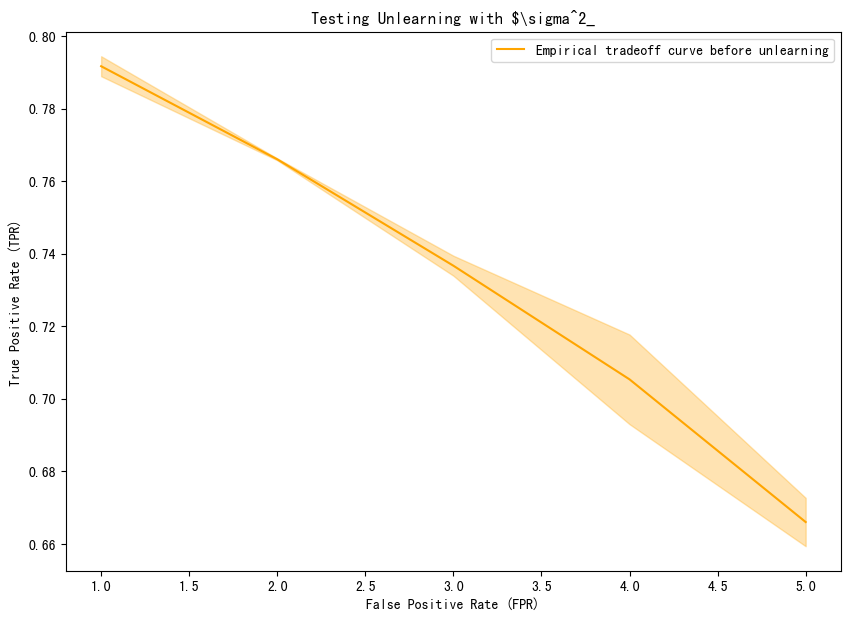

In [52]:
# import numpy as np
# import matplotlib.pyplot as plt

# 示例数据，FPR 是横轴，TPR 是纵轴，err 是误差范围
epochs = np.array([1, 2, 3, 4, 5])

model1base_cossim = np.array(model1base_cossim)
errors = np.array(errors)

scale_factor = 100



# 创建图形
plt.figure(figsize=(10, 7))

# 画出“unlearning前”的实线以及阴影范围
plt.plot(epochs, model1base_cossim, color='orange', label='Empirical tradeoff curve before unlearning')
plt.fill_between(epochs, model1base_cossim - scale_factor * errors, model1base_cossim + scale_factor * errors, color='orange', alpha=0.3)

# 画出“unlearning后”的实线以及阴影范围
# plt.plot(fpr, tpr_after, color='blue', label='Empirical tradeoff curve after unlearning')
# plt.fill_between(fpr, tpr_after - error_after, tpr_after + error_after, color='blue', alpha=0.3)

# 添加标签和标题
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Testing Unlearning with $\sigma^2_')

# 添加图例
plt.legend()

# 显示图形
plt.show()


In [54]:
import wandb
api = wandb.Api()
run = api.run("/akaabel/test_experiments/runs/8qc3g027")
# Show history data:
tmp = run.history()

In [57]:
print(tmp.head())

   model1_val_correct  epoch  model12_cossim  model0_val_loss  \
0                 NaN      0             NaN          1.24256   
1              0.5437      0             NaN              NaN   
2                 NaN      0        0.910973              NaN   
3                 NaN      1             NaN          1.53333   
4              0.6006      1             NaN              NaN   

   model2_val_correct  model2_train_loss  model2base_cossim  _step  \
0                 NaN                NaN                NaN      0   
1                 NaN                NaN                NaN      1   
2                 NaN                NaN           0.798417      2   
3                 NaN                NaN                NaN      3   
4                 NaN                NaN                NaN      4   

     _timestamp  model0_train_loss    _runtime  model1base_cossim  \
0  1.727615e+09            1.39703   73.988813                NaN   
1  1.727615e+09                NaN   99.611957    